# Figure Six: PFSS Model

- Top Panel: Full Carrington EUV map with PFSS model overlaid
    - footpoints
    - trajectory
    - HCS
- Bottom Panels: zoom in of top panel onto three regions of interest

## Imports

In [17]:
import sys, os
import astropy.units as u

import datetime
import numpy as np
import pandas as pd
import scipy.constants as con
from scipy import stats
import scipy.stats as stats
from scipy.interpolate import interp1d
from pandas.tseries.frequencies import to_offset

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


import sunpy
import astrospice
from astropy.time import Time
from pyspedas import time_string

import tools.utilities as utils
import tools.psp_funcs as psp_funcs
import tools.pfss_funcs as pfss_funcs


for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# COLORS
c = ['#ae017e','#085A99',  '#c98000'] # darker colors
lightc = ['#FCA4C4',  '#8FD3F4', '#FFCC70'] # lighter colors
fcol = 'mistyrose'
sacol='lavender'
scol = 'violet'
hcol = 'lightblue'
pcol = 'lightgreen'
aa = 0.6
lw=2
clon = c[0]
clat = c[1]
rcol = 'dimgrey'
cmaps = ['RdPu', 'cool', 'Wistia', 'spring'] # velocity, density, magnetic field

# REGIONS
loc_hcs = [112, 115]
pseud = [166.5, 173]
fsw = [70, 85]
ssw = [150, 166.5]
sasw = [173, 185]

# DIRECTORIES
IMG_DIR = './figures'
DF_DIR = './results'
PlotDir = '/Users/tamarervin/mplstyle/'


# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 16})
plt.style.use(plot_style)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

02-Aug-23 13:53:38: /Users/tamarervin/miniconda3/envs/e11_conjunction/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [3]:
# regular data
parker = pd.read_csv('/Users/tamarervin/e11_conjunction/results/parker.csv')
orbiter = pd.read_csv('/Users/tamarervin/e11_conjunction/results/orbiter.csv')
abun = pd.read_csv('/Users/tamarervin/e11_conjunction/results/abun.csv')
smag = pd.read_csv('/Users/tamarervin/e11_conjunction/results/solo_mag.csv')
merged_df = pd.read_csv('/Users/tamarervin/e11_conjunction/results/merged_df.csv')
pss = pd.read_csv('/Users/tamarervin/e11_conjunction/results/pss.csv')

# timesampled data
parkerdownt = pd.read_csv('/Users/tamarervin/e11_conjunction/results/parkerdownt.csv')
orbiterdownt = pd.read_csv('/Users/tamarervin/e11_conjunction/results/orbiterdownt.csv')
abundownt = pd.read_csv('/Users/tamarervin/e11_conjunction/results/abundownt.csv')
smagdownt = pd.read_csv('/Users/tamarervin/e11_conjunction/results/smagdownt.csv')

# longitudinally sampled data
parkerdownl = pd.read_csv('/Users/tamarervin/e11_conjunction/results/parkerdownl.csv')
orbiterdownl = pd.read_csv('/Users/tamarervin/e11_conjunction/results/orbiterdownl.csv')
abundownl = pd.read_csv('/Users/tamarervin/e11_conjunction/results/abundownl.csv')
smagdownl = pd.read_csv('/Users/tamarervin/e11_conjunction/results/smagdownl.csv')

# PFSS/MHD data
tracerdf = pd.read_csv('/Users/tamarervin/e11_conjunction/mhd/mhd_footpoints.dat', sep='\s+') 
so_tracerdf = pd.read_csv('/Users/tamarervin/e11_conjunction/mhd/so_mhd_footpoints.dat', sep='\s+')
pfss = pd.read_csv('/Users/tamarervin/e11_conjunction/results/psp_pfss.csv')
so_pfss = pd.read_csv('/Users/tamarervin/e11_conjunction/results/so_pfss.csv')

# FIX TIMESTAMPS
parker['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in parker.Time]
orbiter['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in orbiter.Time]
pss['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in pss.Time]
smag['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in smag.Time]
abun['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f') for d in abun.Time]
so_pfss['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in so_pfss.times]
parkerdownt['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in parkerdownt.Time]
orbiterdownt['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in orbiterdownt.Time]
smagdownt['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in smagdownt.Time]
abundownt['Time'] = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in abundownt.Time]


## Run PFSS Model

In [4]:
# download/read in magnetogram
rss=2.0
local_path = "../data/"
filename = 'adapt40311_03k012_202202240000_i00005600n1.fts.gz'
filepath = f"{local_path}/{filename}"
adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)
gong_map = sunpy.map.Map(adapt_magnetogram.data/1e5, adapt_magnetogram.meta)

# run PFSS model
pfss_model = pfss_funcs.adapt2pfsspy(filepath,rss)

# trace PFSS lines
flines = pfss_funcs.pfss2flines(pfss_model)

02-Aug-23 13:49:42: Missing metadata for solar radius: assuming the standard radius of the photosphere.
02-Aug-23 13:49:42: /Users/tamarervin/miniconda3/envs/e11_conjunction/lib/python3.11/site-packages/sunpy/map/mapbase.py:625: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs

  obs_coord = self.observer_coordinate

02-Aug-23 13:49:43: Missing metadata for solar radius: assuming the standard radius of the photosphere.
02-Aug-23 13:49:43: /Users/tamarervin/miniconda3/envs/e11_conjunction/lib/python3.11/site-packages/sunpy/map/mapbase.py:625: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


02-Aug-23 13:49:49: /Users/tamarervin/miniconda3/envs/e11_conjunction/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(



In [5]:
# get PSP at source surface
# get datetimes from fields dataframe
pdatetimes = parker.Time

# get inertial PSP coordinates 
kernels = astrospice.registry.get_kernels('psp', 'predict')
psp_coords_inertial = astrospice.generate_coords('SOLAR PROBE PLUS', pdatetimes)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
psp_coords_carr = psp_coords_inertial.transform_to(
sunpy.coordinates.HeliographicCarrington(observer="self"))

# get psp longitude and latitude at source surface
psp_at_source_surface = psp_funcs.coord_projection(psp_coords_carr, rss, pdatetimes)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [6]:
# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# get trajectory 
polarity = np.sign(parker.BrR2)
pos = np.where(polarity == 1)
neg = np.where(polarity == -1)

# get field lines
flines_psp = pfss_funcs.pfss2flines(pfss_model, skycoord_in=psp_at_source_surface)

# high res field lines
flines_highres = pfss_funcs.pfss2flines(pfss_model,nth=181,nph=361)

# get field line topology defined by polarity
topologies = flines_highres.polarities.reshape([181,361])

02-Aug-23 13:50:38: /Users/tamarervin/miniconda3/envs/e11_conjunction/lib/python3.11/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(



## Plotting Function

In [18]:
def plot_pfss(smap, hcs, source_surface, flines, datetimes, ax, nf=16, dim=[0, 360, -90, 90], flines_so=None, tm=7, traj=False, dd=True, yl=True, fp=True):

    # plot on axes
    plt.sca(ax)
    
    # color dictionary
    color_dict = {-1:"blue", 0:"black", 1:"red"}
    
    # plot euv map
    if type(smap) == sunpy.map.mapbase.GenericMap:
        lons = np.linspace(0, 360, 721)
        lats = np.linspace(-90, 90, 361)
        lognorm = mpl.colors.LogNorm(vmin=np.nanpercentile(smap.data.flatten(),10), 
                                vmax=np.nanpercentile(smap.data.flatten(),99.9))
        ax.pcolormesh(lons, lats, smap.data, cmap='sdoaia193', norm=lognorm, zorder=-1)
    else:
        lons = np.linspace(0, 360, 361)
        lats = np.linspace(-90, 90, 181)
        ax.pcolormesh(lons,lats,topologies,cmap="coolwarm", zorder=-1)
        
    # plot HCS
    ax.plot(hcs.lon, hcs.lat, color='white', label='HCS', zorder=0)

    # plot field lines
    for f in flines_psp[::nf] :
        fcoords = f.coords
        fcoords.representation_type="spherical"
        ax.plot(fcoords.lon,
                fcoords.lat,
                # fcoords.z.to("R_sun"),
                color = color_dict.get(f.polarity), 
                linewidth=0.5, alpha=0.5, zorder=1
            )

    # plot trajectory
    polarity = np.sign(parker.BrR2)
    pos = np.where(polarity == 1)
    neg = np.where(polarity == -1)
    ax.scatter(source_surface.lon[neg], source_surface.lat[neg], color='navy', label='Negative Polarity', zorder=2, s=3)
    ax.scatter(source_surface.lon[pos], source_surface.lat[pos], color='darkred',label='Positive Polarity', zorder=3, s=3)

    # add regions of interest
    lon_footpoints = flines.open_field_lines.solar_feet.lon.value[::nf]
    lat_footpoints = flines.open_field_lines.solar_feet.lat[::nf]
    fast = np.logical_and(lon_footpoints >= fsw[0], lon_footpoints <=fsw[1])
    slow = np.logical_and(lon_footpoints >= ssw[0], lon_footpoints <=ssw[1])
    salf = np.logical_and(lon_footpoints >= sasw[0], lon_footpoints <=sasw[1])

    # plot footpoints
    ax.scatter(lon_footpoints, lat_footpoints, s=6, color='grey', marker='D')
    ax.scatter(lon_footpoints[fast], lat_footpoints[fast], s=6, color=fcol, marker='D')
    ax.scatter(lon_footpoints[slow], lat_footpoints[slow], s=6, color=scol, marker='D')
    ax.scatter(lon_footpoints[salf], lat_footpoints[salf], s=6, color=sacol, marker='D')

    # plot dates
    if dd:
        dates = [i.date() for i in datetimes]
        dates_str = [d.strftime('%m-%d-%Y') for d in dates]
        psp_inds = [np.where(np.array(dates_str) == d)[0][0] for d in np.unique(dates_str)[0::2]]
        labels = np.unique(dates_str)[0::2]
        for i, x in enumerate(list(zip(psp_at_source_surface.lon[psp_inds], psp_at_source_surface.lat[psp_inds]))):
            label = labels[i]
            if i <3:
                ax.text(x[0].value - 2, x[1].value + 2, label[:-5], ha="center", va="bottom", color='white', rotation=45, size='medium', zorder=5)
            elif 3 <= i < 6:
                ax.text(x[0].value - 1, x[1].value - 16, label[:-5], ha="center", va="bottom", color='white', rotation=45, size='medium', zorder=5)
            else:
                ax.text(x[0].value - 1, x[1].value + 4, label[:-5], ha="center", va="bottom", size="medium", color='white', rotation=45, zorder=5)
    # plot solar orbiter
    if flines_so:
        for f in flines_so[::nf]:
            fcoords = f.coords
            fcoords.representation_type="spherical"
            ax.plot(fcoords.lon,
                    fcoords.lat,
                    # fcoords.z.to("R_sun"),
                    color = color_dict.get(f.polarity), 
                    linewidth=0.5, alpha=0.5, zorder=1
                )
        
        # plot the SolO trajectory on top of it
        pos = np.where(so_pol == 1)
        neg = np.where(so_pol == -1)
        ax.scatter(solo_at_source_surface.lon[neg], solo_at_source_surface.lat[neg], color='navy', s=10,
        label='Negative Polarity', zorder=2)
        ax.scatter(solo_at_source_surface.lon[pos], solo_at_source_surface.lat[pos], color='darkred', s=10, 
        label='Positive Polarity', zorder=3)

        # solo orbiter footpoints
        lon_footpoints = flines_so.open_field_lines.solar_feet.lon.value[::nf]
        lat_footpoints = flines_so.open_field_lines.solar_feet.lat[::nf]
        fast = np.logical_and(lon_footpoints >= 70, lon_footpoints <=90)
        salf1 = np.logical_and(lon_footpoints >= 113, lon_footpoints <=133)
        salf2 = np.logical_and(lon_footpoints >= 170, lon_footpoints <=190)

        # plot footpoints
        ax.scatter(lon_footpoints, lat_footpoints, s=6, color='lightgreen', marker='*')
        ax.scatter(lon_footpoints[fast], lat_footpoints[fast], s=6, color='lightgreen', marker='*')
        ax.scatter(lon_footpoints[salf1], lat_footpoints[salf1], s=6, color='lightgreen', marker='*')
        ax.scatter(lon_footpoints[salf2], lat_footpoints[salf2], s=6, color='lightgreen', marker='*')


    # trajectory legend
    if traj:
        red_patch = mpatches.Patch(color='darkred', label='Positive Polarity')
        blue_patch = mpatches.Patch(color='navy', label='Negative Polarity')
        hcs_patch = mpatches.Patch(color='white', label='HCS')
        leg1 = ax.legend(handles=[hcs_patch, red_patch, blue_patch], loc='upper left')
        ax.add_artist(leg1)

    # footpoints legend
    if fp:
        fleg = mpatches.Patch(color='pink', label='Fast Wind')
        saleg = mpatches.Patch(color=sacol, label='Slow Alfvenic Wind')
        sleg = mpatches.Patch(color=scol, label='Classical Slow Wind')
        footpoints = mpatches.Patch(color='grey', label='Footpoints')
        leg2 = ax.legend(handles=[footpoints, fleg, saleg, sleg], loc='upper right')
        ax.add_artist(leg2)

    # title and labels
    ax.set_xlim((dim[0], dim[1]))
    ax.set_ylim((dim[2], dim[3]))
    ax.set_xticks(np.linspace(dim[0], dim[1], tm))
    ax.set_yticks(np.linspace(dim[2], dim[3], tm))
    ax.set_xlabel("Carrington Longitude [deg]")
    if yl:
        ax.set_ylabel("Carrington Latitude [deg]")

    return ax

## Create Plot

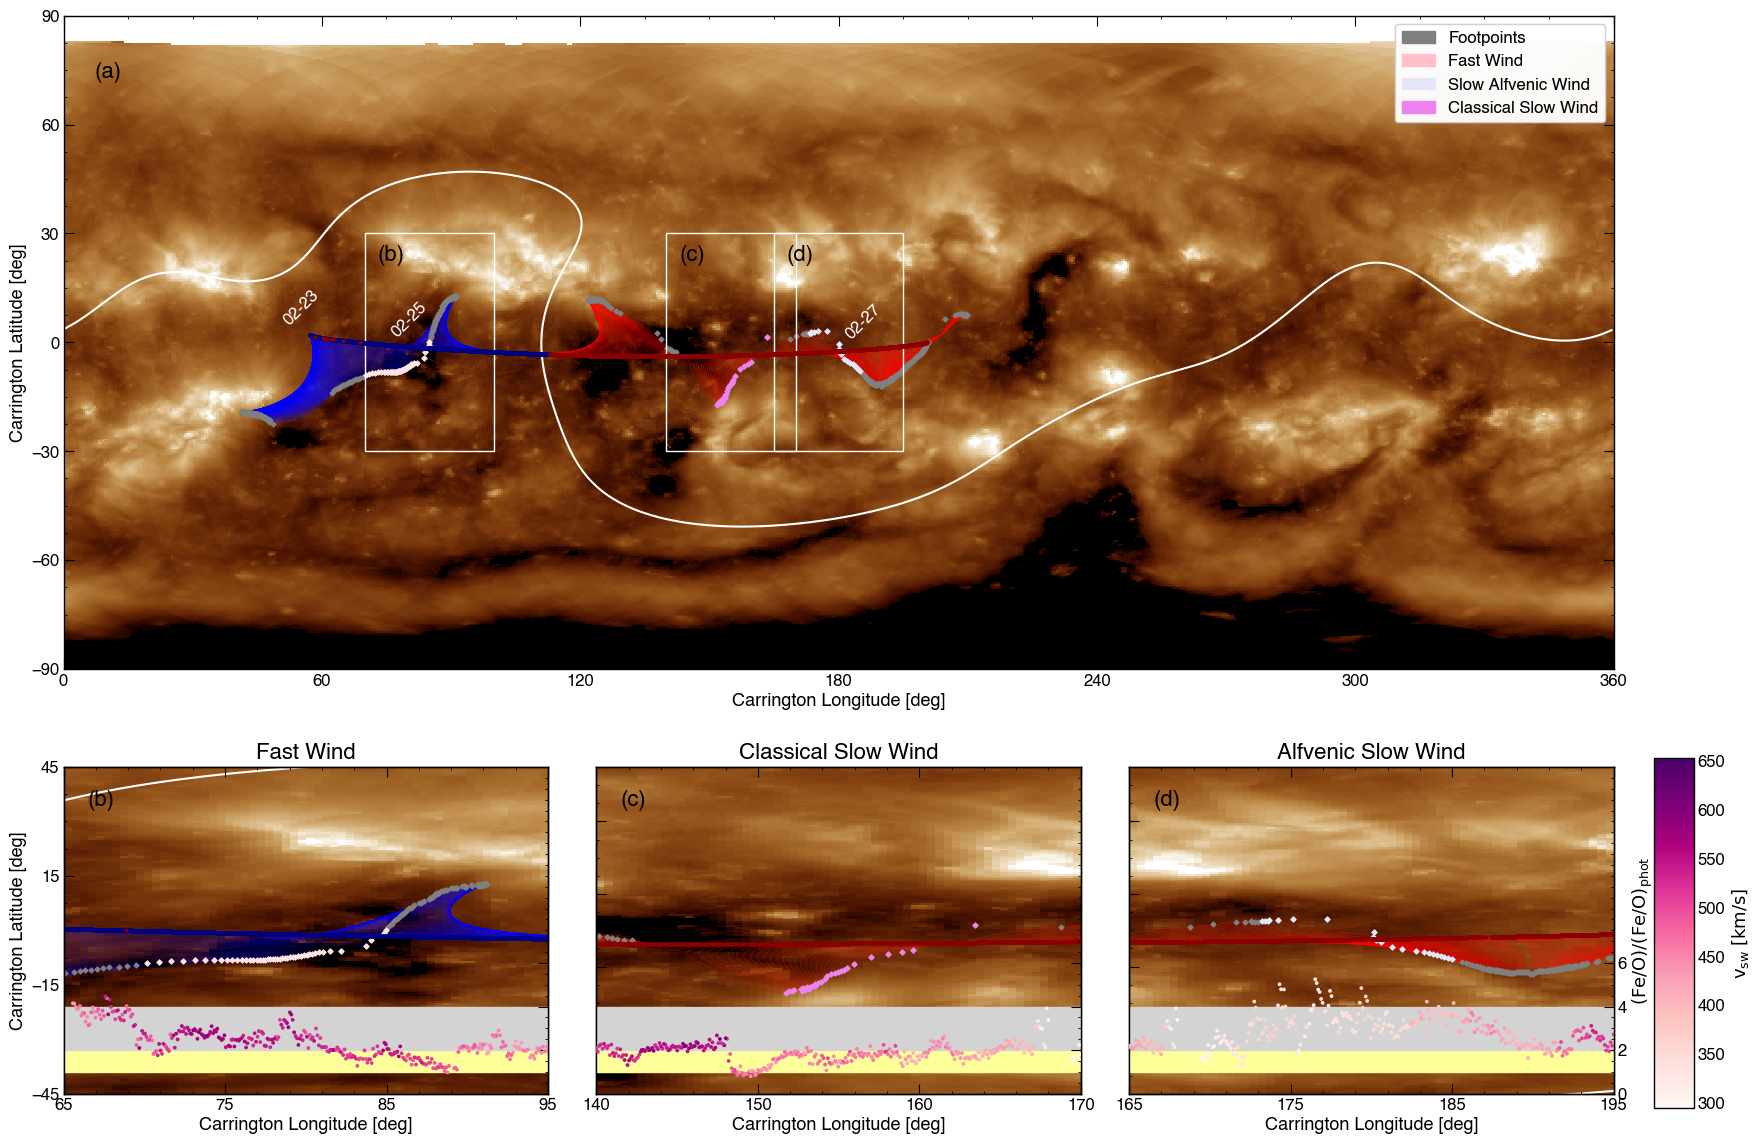

In [21]:
# look at elemental composition as function of wind speed
fig = plt.figure(figsize=(20, 14))
grid = plt.GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1], hspace=0.2, wspace=0.1)
nf = 16

# create plots
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
ax4 = fig.add_subplot(grid[1, 2])
axs = [ax1, ax2, ax3, ax4]

##### -------- PLOT PFSS FIGURE ------- #####
# euv map
synoptic = '/Users/tamarervin/e11_conjunction/data/2022-02-22_0193.fits'
smap = sunpy.map.Map(synoptic)

# coronal hole map
# ch_path = 'data/E11_14days_fortranCHD.fits'
# ch_obs_map = sunpy.map.Map(ch_path)

# plot full pfss map
plot_pfss(smap, hcs, psp_at_source_surface, flines_psp, pdatetimes, ax=ax1, nf=16)

# connect corners
lab = ['(b)', '(c)', '(d)']
for i, rect_x in enumerate([70, 140, 165]):
    # add rectangle
    rect = mpl.patches.Rectangle((rect_x, -30), 30, 60, linewidth=1, edgecolor='white', facecolor='none')
    ax1.add_patch(rect) 
    rect_corners = [(rect_x, -30),
                    (rect_x + 30, -30),
                    (rect_x + 30, 30),
                    (rect_x, 30)]
    ax1.text(rect_x + 3, 27, lab[i], fontsize=16, fontweight='bold', va='top', ha='left', color='black')

# plot fast wind region
plot_pfss(smap, hcs, psp_at_source_surface, flines_psp, pdatetimes, ax=ax2, nf=16, dim=[65, 95, -45, 45], tm=4, fp=False, dd=False)
ax2.set_title('Fast Wind')

# plot slow wind region 1
plot_pfss(smap, hcs, psp_at_source_surface, flines_psp, pdatetimes, ax=ax3, nf=16, dim=[140, 170, -45, 45], tm=4, fp=False, dd=False, yl=False)
ax3.set_title('Classical Slow Wind')
ax3.set_yticks([-30, -10, 10, 30])
ax3.set_yticklabels([])

# plot slow wind region 2
plot_pfss(smap, hcs, psp_at_source_surface, flines_psp, pdatetimes, ax=ax4, nf=16, dim=[165, 195, -45, 45], tm=4, fp=False, dd=False, yl=False)
ax4.set_title('Alfvenic Slow Wind')
ax4.set_yticks([-30, -10, 10, 30])
ax4.set_yticklabels([])

# add velocity and Fe/O ratio
for ax in [ax2, ax3, ax4]:
    axf = ax.twinx()
    axf.axhspan(1, 2, alpha=1, color='#FFFF99', zorder=-1)
    axf.axhspan(2, 4, alpha=1, color='#D3D3D3', zorder=-1)
    im = axf.scatter(merged_df.lon_x, merged_df.iron/0.0589, c=merged_df.vel, cmap=cmaps[0], s=3, zorder=5)
    axf.set_ylim(0, 15)
    axf.set_yticklabels([])
    axf.set_yticks([0, 2, 4, 6])
axf.set_yticks([0, 2, 4, 6])
axf.set_yticklabels([0, 2, 4, 6])
axf.set_ylabel(r'$\rm (Fe/O)/(Fe/O)_{phot}$')

# add panel labels
ax2.text(0.02, 0.93, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
ax2.text(0.05, 0.93, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
ax3.text(0.05, 0.93, '(c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')
ax4.text(0.05, 0.93, '(d)', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='left', color='black')

# add velocity colorbar
cax = fig.add_axes([0.92, 0.10, 0.02, 0.25]) # [left, bottom, width, height]

# Add the colorbar to the separate Axes
cbar = fig.colorbar(im, cax=cax)

# Add labels to the colorbar and adjust its position
cbar.set_label(r'$\rm v_{sw} \; [km/s]$')
cax.yaxis.set_label_position('right')

plt.savefig('figures/pfss_subplots.png')